# 更多图像滤波
Hawk Wang


** 请关注我的知乎专栏[https://zhuanlan.zhihu.com/hawkcp], 获取更多信息 **

这一份notebook将展示我在讲义中提到的进一步图像滤波的知识，主要包括如下几个部分的内容

- 模板匹配
- 线性移不变滤波器
    - 形态学滤波
    - Lens Blur
    - 双边滤波
    - 非局部均值滤波
    
以下是所有内容的脑图总结
![](./imgs/更多图像滤波.png)

### 0. 导入必要的库
首先还是将这里用到的所有的python package引用进来

- Image及skimage中的imread: 用于读取图像
- numpy: 用于用矩阵形式来管理图像
- matplotlib: 用于可视化数据
- Axes3D: 用于3D可视化图像
- cv2: 即OpenCV，用于对图像进行高级的处理

特别注意的是，为了在notebook中顺利的可视化图像，通常需要加入如下这一句：

```%matplotlib inline```

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from skimage.io import imread
%matplotlib inline


### 1. 模板匹配

我们这里需要通过一张爱因斯坦的眼睛的图片去找到下面爱因斯坦照片中他的双眼的位置

![爱因斯坦的眼睛](./imgs/einstein_eye.png)

![爱因斯坦的人像](./imgs/einstein_org.png)


#### 1. 读入图像并显示

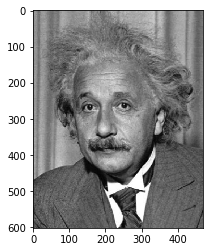

In [51]:
img=cv2.imread('./imgs/einstein_org.png')
plt.imshow(img)
plt.show()

#### 方案1： 直接用爱因斯坦的眼睛局部图像去卷积原图
![](./imgs/einstein_filter1.png)

In [54]:
eye=cv2.imread('./imgs/einstein_eye.png')
filteredImg1=cv2.filter2D(img.astype(np.float64), -1, eye)
filteredImg1=255 * (filteredImg1-filteredImg1.min())/(filteredImg1.max()-filteredImg1.min())
filteredImg1=filteredImg1.astype(np.uint8)

In [55]:
def showFilterResult(img,eye,filteredResult,suptitle):
    plt.figure(figsize=(15,5))
    plt.suptitle(suptitle, fontsize=14)
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.subplot(1,3,2)
    plt.imshow(eye)
    plt.title("Filter Kernel")
    plt.subplot(1,3,3)
    plt.imshow(filteredResult, cmap="gray")
    plt.title("Filter Result")
    plt.show()

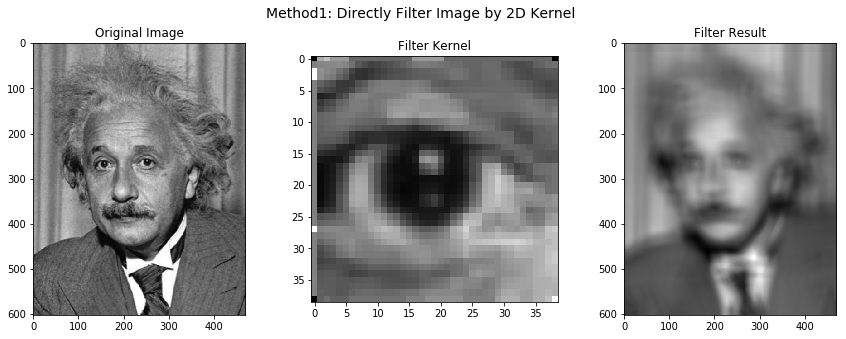

In [56]:
showFilterResult(img,eye,filteredImg1, "Method1: Directly Filter Image by 2D Kernel")

很明显，不仅眼睛处的响应比较高，胸前衬衫处也得到了很高的响应，我们没有达到找到眼睛的目的。观察上述公式，可以知道输出结果是跟图像的局部区域的像素值正相关的，衬衫很白，像素值很大，最终的响应值也自然很大。

因此这给了我们一个启发：输出值不能跟原始像素的绝对值相关。为此，可以采用下面的方案：

#### 方案2： 利用0均值模板去滤波
![](./imgs/einstein_filter2.png)

In [57]:
eye_0mean=eye-eye.mean()

In [58]:
filteredImg2=cv2.filter2D(img.astype(np.float64), -1, eye_0mean)
filteredImg2=255 * (filteredImg2-filteredImg2.min())/(filteredImg2.max()-filteredImg2.min())
filteredImg2=filteredImg2.astype(np.uint8)
filteredImg2[filteredImg2<200]=0
filteredImg2=cv2.rectangle(filteredImg2,(120,230),(200,300),color=(255,0,0),thickness=2)
filteredImg2=cv2.rectangle(filteredImg2,(180,370),(400,570),color=(0,255,255),thickness=2)

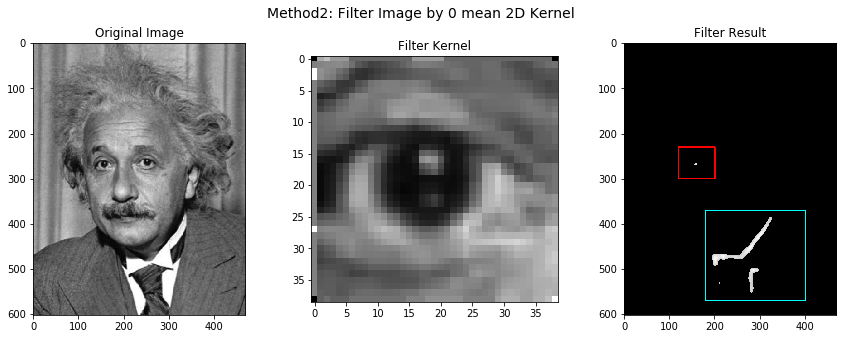

In [59]:
showFilterResult(img,eye,filteredImg2, "Method2: Filter Image by 0 mean 2D Kernel")

此方案会先减去图像的均值，再用结果图与模板进行卷积。它的结果比方案一好，能检测出一只眼睛，但也会引入错误，依然有部分领口的衬衫被错误的当成眼睛检测出来了。可见这种方案还不够鲁棒。

#### 方案3：采用均方误差(SSD)
![](./imgs/einstein_filter3.png)

In [60]:
def filterSSD(img, kernel):
    filteredImg=cv2.matchTemplate(img.astype(np.float32), eye.astype(np.float32), method=cv2.TM_SQDIFF)
    filteredImg=255 * (filteredImg-filteredImg.min())/(filteredImg.max()-filteredImg.min())
    filteredImg=filteredImg.astype(np.uint8)
    filteredImg[filteredImg>0]=255
    filteredImg=255-filteredImg
    filteredImg=cv2.rectangle(filteredImg,(120,230),(200,300),color=(255,255,255),thickness=2)
    return filteredImg.astype(np.uint8)

filteredImg3 = filterSSD(img, eye)


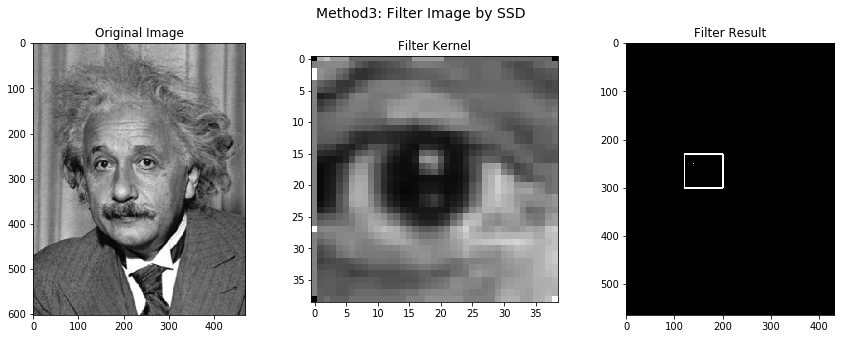

In [61]:
showFilterResult(img,eye,filteredImg3, "Method3: Filter Image by SSD")

此方案效果比较好，很明显它检测出了眼睛，并且没有引入误匹配区域。 然而这种方法高度依赖于图像的对比度，如果图像的颜色收到干扰，那么立刻就会导致错误。例如，我们在源图像上加一些信息如下，可以看到结果中爱因斯坦身上的响应大大超过了眼睛的响应。

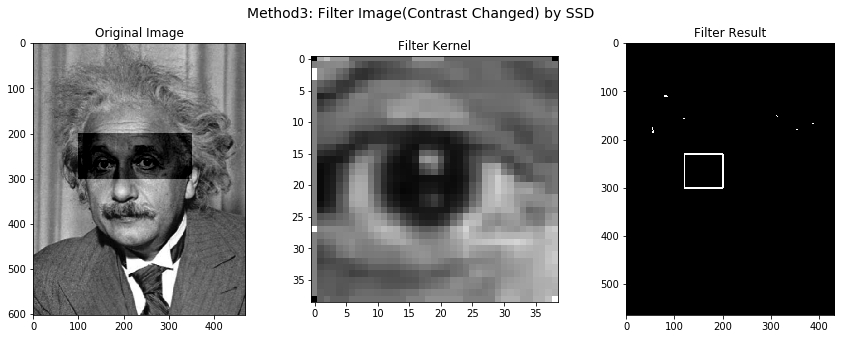

In [62]:
imgNoise=img.copy().astype(np.float32)
imgNoise[200:300,100:350]-=100
imgNoise[200:300,100:350][imgNoise[200:300,100:350]<0]=0
imgNoise=imgNoise.astype(np.uint8)

filteredImg32=filterSSD(imgNoise, eye)
showFilterResult(imgNoise,eye,filteredImg32, "Method3: Filter Image(Contrast Changed) by SSD")

#### 方案4：采用归一化互相关系数(NCC)

![](./imgs/einstein_filter4.png)

归一化互相关系数（NCC)是最为鲁棒的一种方案，它能够比较准确的检测出爱因斯坦的眼睛，而且对于图像的局部对比度收到干扰的情况也很鲁棒，见下面的结果, 即便在原图的眼睛周围加上干扰遮罩，检测结果依然一致

In [63]:
def filterNCC(img, kernel, threshold):
    filteredImg=cv2.matchTemplate(img.astype(np.float32), eye.astype(np.float32), method=cv2.TM_CCOEFF_NORMED)
    filteredImg=255 * (filteredImg-filteredImg.min())/(filteredImg.max()-filteredImg.min())
    filteredImg[filteredImg<threshold]=0
    filteredImg=cv2.rectangle(filteredImg,(120,230),(200,300),color=(255,255,255),thickness=2)
    return filteredImg

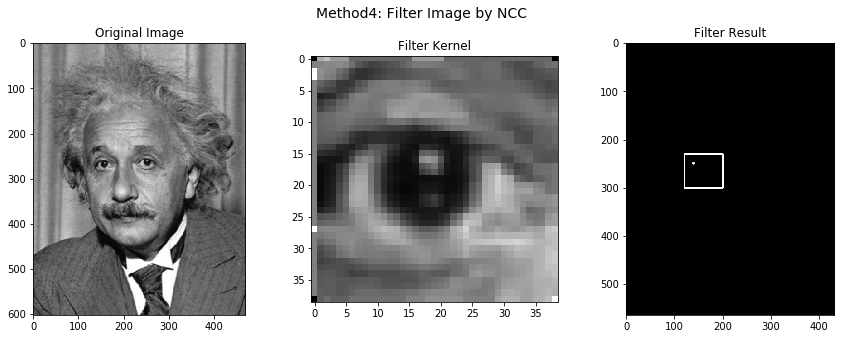

In [66]:
filteredImg4 = filterNCC(img, eye,200)
showFilterResult(img,eye,filteredImg4, "Method4: Filter Image by NCC")

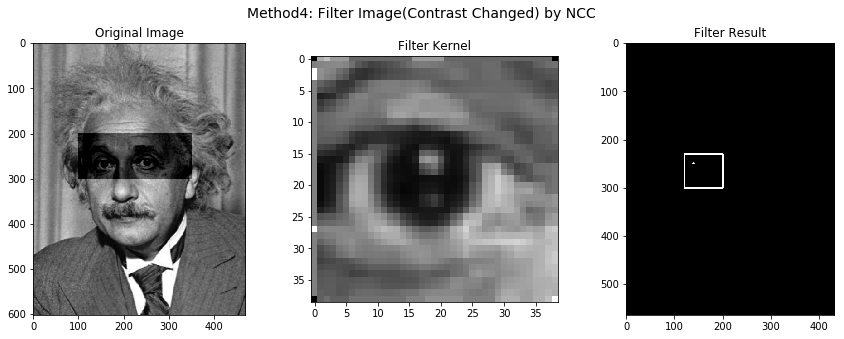

In [67]:
filteredImg42 = filterNCC(imgNoise, eye,220)
showFilterResult(imgNoise,eye,filteredImg42, "Method4: Filter Image(Contrast Changed) by NCC")

### 2. 非线性移不变滤波器

#### 1. 膨胀和腐蚀

膨胀操作可以根据设定的结构元素来扩张一个二值图像，它实际上是用结构元素窗口内的有效像素的"或"结果来替代目标像素的值，如下图
![](./imgs/dilate.png)

腐蚀操作则相反，如下
![](./imgs/erode.png)

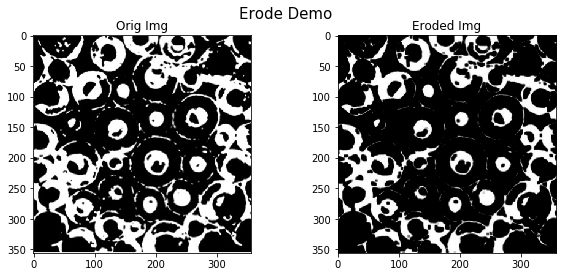

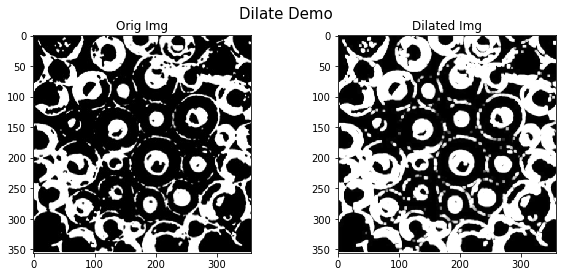

In [69]:
def compareImg(img1, img2, suptitle, title1, title2):
    plt.figure(figsize=(10,4))
    plt.suptitle(suptitle, fontsize=15)
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title(title1)
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title(title2)
    plt.show()
    
img=cv2.imread('./imgs/binary.jpg')
erodeImg=cv2.erode(img, np.array([]))
dilateImg=cv2.dilate(img, np.array([]))
compareImg(img, erodeImg, "Erode Demo", "Orig Img", "Eroded Img")
compareImg(img, dilateImg, "Dilate Demo", "Orig Img", "Dilated Img")

下面展示了图像边缘检测采用膨胀腐蚀操作的过程，可见只要选择合适的窗口大小，合适的操作顺序，就可以检测出特定图像的边缘。

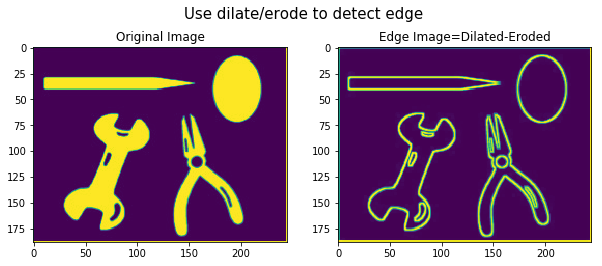

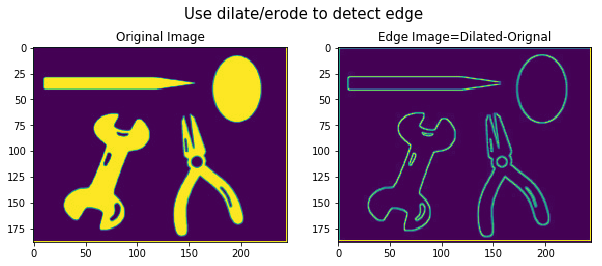

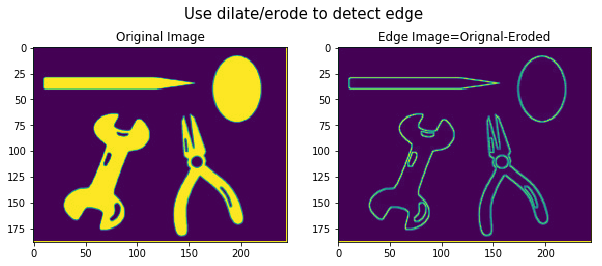

In [145]:
ftools=cv2.imread('./imgs/ftools.jpg', cv2.IMREAD_GRAYSCALE)
ftools_dilated=cv2.dilate(ftools, kernel=np.array([]))
ftools_eroded=cv2.erode(ftools, kernel=np.array([]))
edge1=ftools_dilated-ftools_eroded
edge2=ftools_dilated-ftools
edge3=ftools-ftools_eroded
compareImg(ftools, edge1, 'Use dilate/erode to detect edge', 'Original Image', 'Edge Image=Dilated-Eroded')
compareImg(ftools, edge2, 'Use dilate/erode to detect edge', 'Original Image', 'Edge Image=Dilated-Orignal')
compareImg(ftools, edge3, 'Use dilate/erode to detect edge', 'Original Image', 'Edge Image=Orignal-Eroded')

#### 2. 双边滤波 vs 高斯滤波 vs 非局部均值滤波

![](./imgs/bilateral_gauss.png)

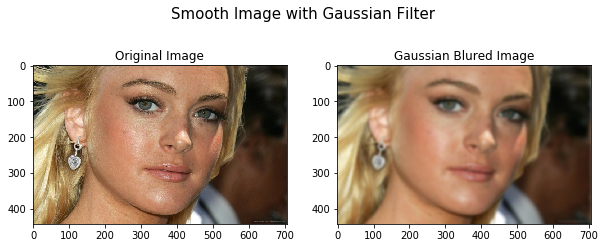

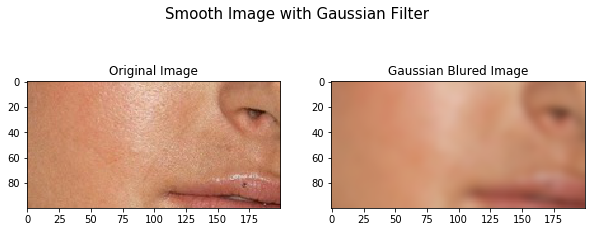

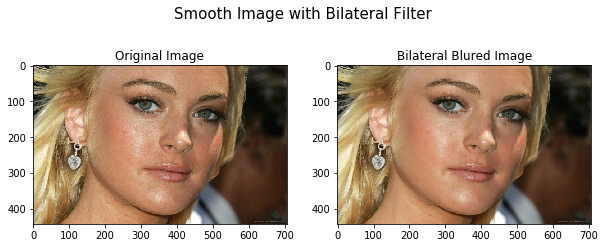

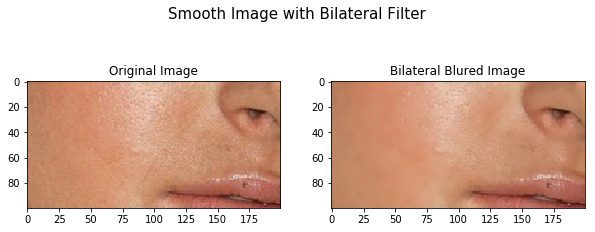

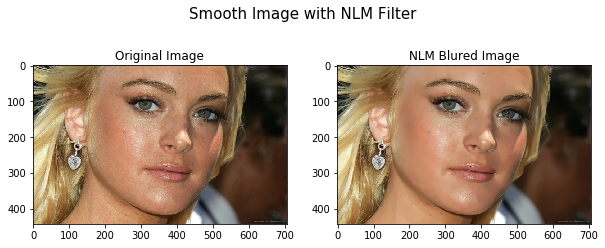

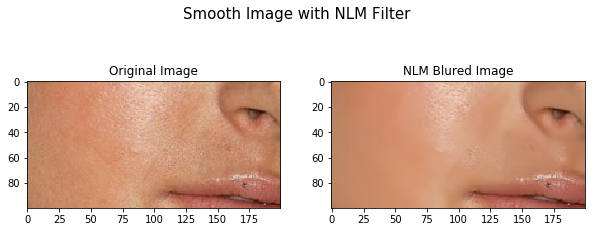

In [192]:
girl=cv2.imread('./imgs/girl.jpg')[:,:,2::-1]
girlGf=cv2.GaussianBlur(girl, (0,0), 3, 3)
girlBlf=cv2.bilateralFilter(girl,-1,20,3)
girlNlm=cv2.fastNlMeansDenoising(girl,h=5)
compareImg(girl, girlGf, 'Smooth Image with Gaussian Filter', 'Original Image', 'Gaussian Blured Image')
compareImg(girl[200:300,200:400], girlGf[200:300,200:400], 'Smooth Image with Gaussian Filter', 'Original Image', 'Gaussian Blured Image')
compareImg(girl, girlBlf, 'Smooth Image with Bilateral Filter', 'Original Image', 'Bilateral Blured Image')
compareImg(girl[200:300,200:400], girlBlf[200:300,200:400], 'Smooth Image with Bilateral Filter', 'Original Image', 'Bilateral Blured Image')
compareImg(girl, girlNlm, 'Smooth Image with NLM Filter', 'Original Image', 'NLM Blured Image')
compareImg(girl[200:300,200:400], girlNlm[200:300,200:400], 'Smooth Image with NLM Filter', 'Original Image', 'NLM Blured Image')

### 3. 总结

这份Notebook主要介绍了图像的模板匹配，以及非线性移不变滤波器，我还展示了一些明显的例子。所有这些滤波器在我们之后的课程中都有可能用到，我在随后还会展示图像的滤波的强大作用。

欢迎你继续关注本仓库，也欢迎关注我的知乎专栏 ”计算摄影学“：https://zhuanlan.zhihu.com/hawkcp